# Twitter Sentiment Analysis

In [1]:
!pip install gensim --upgrade
!pip install keras --upgrade
!pip install pandas --upgrade

Requirement already up-to-date: gensim in /Applications/anaconda3/lib/python3.7/site-packages (3.8.3)
You should consider upgrading via the '/Applications/anaconda3/bin/python -m pip install --upgrade pip' command.
Requirement already up-to-date: keras in /Applications/anaconda3/lib/python3.7/site-packages (2.4.3)
You should consider upgrading via the '/Applications/anaconda3/bin/python -m pip install --upgrade pip' command.
Requirement already up-to-date: pandas in /Applications/anaconda3/lib/python3.7/site-packages (1.1.3)
You should consider upgrading via the '/Applications/anaconda3/bin/python -m pip install --upgrade pip' command.


In [2]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/edisongu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Settings

In [4]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

### Read Dataset

### Dataset details
* **target**: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
* **ids**: The id of the tweet ( 2087)
* **date**: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
* **flag**: The query (lyx). If there is no query, then this value is NO_QUERY.
* **user**: the user that tweeted (robotickilldozr)
* **text**: the text of the tweet (Lyx is cool)

In [5]:
dataset_filename = os.listdir("./input")[0]
dataset_path = os.path.join(".","input",dataset_filename)
print("Open file:", dataset_path)
df = pd.read_csv(dataset_path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

Open file: ./input/training.1600000.processed.noemoticon.csv


In [6]:
print("Dataset size:", len(df))

Dataset size: 1600000


In [7]:
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


### Map target label to String
* **0** -> **NEGATIVE**
* **2** -> **NEUTRAL**
* **4** -> **POSITIVE**

In [8]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [9]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 578 ms, sys: 17.6 ms, total: 596 ms
Wall time: 1.57 s


Text(0.5, 1.0, 'Dataset labels distribuition')

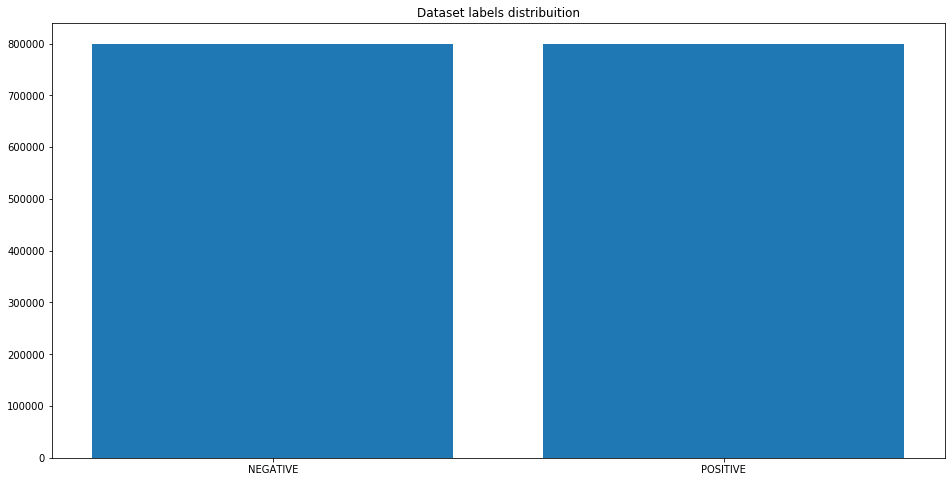

In [10]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

### Pre-Process dataset

In [11]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [12]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [13]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 55.2 s, sys: 951 ms, total: 56.1 s
Wall time: 1min 16s


### Split train and test

In [14]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


### Word2Vec 

In [15]:
%%time
documents = [_text.split() for _text in df_train.text] 

CPU times: user 2.77 s, sys: 365 ms, total: 3.14 s
Wall time: 5.07 s


In [16]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [17]:
w2v_model.build_vocab(documents)

2020-10-28 16:00:13,482 : INFO : collecting all words and their counts
2020-10-28 16:00:13,662 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-10-28 16:00:14,186 : INFO : PROGRESS: at sentence #10000, processed 72565 words, keeping 14005 word types
2020-10-28 16:00:14,217 : INFO : PROGRESS: at sentence #20000, processed 144393 words, keeping 21587 word types
2020-10-28 16:00:14,318 : INFO : PROGRESS: at sentence #30000, processed 215826 words, keeping 27541 word types
2020-10-28 16:00:14,341 : INFO : PROGRESS: at sentence #40000, processed 288271 words, keeping 32764 word types
2020-10-28 16:00:14,428 : INFO : PROGRESS: at sentence #50000, processed 359772 words, keeping 37587 word types
2020-10-28 16:00:14,451 : INFO : PROGRESS: at sentence #60000, processed 431431 words, keeping 42198 word types
2020-10-28 16:00:14,489 : INFO : PROGRESS: at sentence #70000, processed 503103 words, keeping 46458 word types
2020-10-28 16:00:14,558 : INFO : PROGRESS: at s

2020-10-28 16:00:17,993 : INFO : PROGRESS: at sentence #720000, processed 5193881 words, keeping 200325 word types
2020-10-28 16:00:18,054 : INFO : PROGRESS: at sentence #730000, processed 5265467 words, keeping 202133 word types
2020-10-28 16:00:18,089 : INFO : PROGRESS: at sentence #740000, processed 5337518 words, keeping 203818 word types
2020-10-28 16:00:18,149 : INFO : PROGRESS: at sentence #750000, processed 5409321 words, keeping 205535 word types
2020-10-28 16:00:18,175 : INFO : PROGRESS: at sentence #760000, processed 5481512 words, keeping 207282 word types
2020-10-28 16:00:18,219 : INFO : PROGRESS: at sentence #770000, processed 5554093 words, keeping 209076 word types
2020-10-28 16:00:18,269 : INFO : PROGRESS: at sentence #780000, processed 5625382 words, keeping 210805 word types
2020-10-28 16:00:18,359 : INFO : PROGRESS: at sentence #790000, processed 5698066 words, keeping 212618 word types
2020-10-28 16:00:18,387 : INFO : PROGRESS: at sentence #800000, processed 577088

In [18]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30369


In [19]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2020-10-28 16:00:29,482 : INFO : training model with 8 workers on 30369 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2020-10-28 16:00:30,699 : INFO : EPOCH 1 - PROGRESS: at 5.43% examples, 417207 words/s, in_qsize 16, out_qsize 0
2020-10-28 16:00:31,703 : INFO : EPOCH 1 - PROGRESS: at 11.08% examples, 438781 words/s, in_qsize 12, out_qsize 3
2020-10-28 16:00:32,719 : INFO : EPOCH 1 - PROGRESS: at 17.46% examples, 464387 words/s, in_qsize 12, out_qsize 3
2020-10-28 16:00:33,728 : INFO : EPOCH 1 - PROGRESS: at 23.52% examples, 471919 words/s, in_qsize 15, out_qsize 0
2020-10-28 16:00:34,748 : INFO : EPOCH 1 - PROGRESS: at 28.83% examples, 463200 words/s, in_qsize 14, out_qsize 1
2020-10-28 16:00:35,760 : INFO : EPOCH 1 - PROGRESS: at 33.38% examples, 447705 words/s, in_qsize 13, out_qsize 2
2020-10-28 16:00:36,884 : INFO : EPOCH 1 - PROGRESS: at 39.00% examples, 442222 words/s, in_qsize 11, out_qsize 4
2020-10-28 16:00:37,897 : INFO : EPOCH 1 - PROGRESS: 

2020-10-28 16:01:29,199 : INFO : EPOCH 3 - PROGRESS: at 90.00% examples, 398591 words/s, in_qsize 15, out_qsize 0
2020-10-28 16:01:30,364 : INFO : EPOCH 3 - PROGRESS: at 93.92% examples, 391295 words/s, in_qsize 13, out_qsize 2
2020-10-28 16:01:31,366 : INFO : EPOCH 3 - PROGRESS: at 97.18% examples, 385249 words/s, in_qsize 15, out_qsize 0
2020-10-28 16:01:31,949 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-10-28 16:01:32,040 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-10-28 16:01:32,103 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-10-28 16:01:32,105 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-10-28 16:01:32,122 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-28 16:01:32,135 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-28 16:01:32,141 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-28 16:01:32,1

2020-10-28 16:02:23,789 : INFO : EPOCH 6 - PROGRESS: at 19.51% examples, 386142 words/s, in_qsize 15, out_qsize 0
2020-10-28 16:02:24,833 : INFO : EPOCH 6 - PROGRESS: at 25.48% examples, 402900 words/s, in_qsize 15, out_qsize 0
2020-10-28 16:02:25,845 : INFO : EPOCH 6 - PROGRESS: at 30.46% examples, 403247 words/s, in_qsize 16, out_qsize 0
2020-10-28 16:02:26,854 : INFO : EPOCH 6 - PROGRESS: at 35.65% examples, 406093 words/s, in_qsize 15, out_qsize 0
2020-10-28 16:02:27,866 : INFO : EPOCH 6 - PROGRESS: at 40.08% examples, 400522 words/s, in_qsize 15, out_qsize 0
2020-10-28 16:02:28,898 : INFO : EPOCH 6 - PROGRESS: at 45.16% examples, 401093 words/s, in_qsize 14, out_qsize 1
2020-10-28 16:02:29,939 : INFO : EPOCH 6 - PROGRESS: at 50.45% examples, 402948 words/s, in_qsize 16, out_qsize 0
2020-10-28 16:02:30,941 : INFO : EPOCH 6 - PROGRESS: at 55.64% examples, 405119 words/s, in_qsize 16, out_qsize 0
2020-10-28 16:02:32,037 : INFO : EPOCH 6 - PROGRESS: at 60.74% examples, 403059 words/s,

2020-10-28 16:03:18,935 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-28 16:03:18,948 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-28 16:03:18,963 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-28 16:03:18,963 : INFO : EPOCH - 8 : training on 9227204 raw words (8222727 effective words) took 15.5s, 530500 effective words/s
2020-10-28 16:03:20,007 : INFO : EPOCH 9 - PROGRESS: at 7.93% examples, 631292 words/s, in_qsize 16, out_qsize 0
2020-10-28 16:03:21,021 : INFO : EPOCH 9 - PROGRESS: at 17.35% examples, 697559 words/s, in_qsize 15, out_qsize 1
2020-10-28 16:03:22,053 : INFO : EPOCH 9 - PROGRESS: at 26.45% examples, 706748 words/s, in_qsize 16, out_qsize 0
2020-10-28 16:03:23,078 : INFO : EPOCH 9 - PROGRESS: at 35.75% examples, 716860 words/s, in_qsize 15, out_qsize 0
2020-10-28 16:03:24,208 : INFO : EPOCH 9 - PROGRESS: at 41.92% examples, 659088 words/s, in_qsize 14, out_qsize 1
2020-10-28 16:03:25,

2020-10-28 16:04:08,871 : INFO : EPOCH 12 - PROGRESS: at 77.85% examples, 478130 words/s, in_qsize 14, out_qsize 1
2020-10-28 16:04:09,876 : INFO : EPOCH 12 - PROGRESS: at 84.26% examples, 481266 words/s, in_qsize 15, out_qsize 0
2020-10-28 16:04:10,897 : INFO : EPOCH 12 - PROGRESS: at 90.33% examples, 481755 words/s, in_qsize 15, out_qsize 0
2020-10-28 16:04:11,927 : INFO : EPOCH 12 - PROGRESS: at 98.14% examples, 490541 words/s, in_qsize 16, out_qsize 2
2020-10-28 16:04:12,044 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-10-28 16:04:12,080 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-10-28 16:04:12,111 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-10-28 16:04:12,132 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-10-28 16:04:12,142 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-28 16:04:12,171 : INFO : worker thread finished; awaiting finish of 2 more th

2020-10-28 16:05:00,538 : INFO : EPOCH 15 - PROGRESS: at 72.10% examples, 478907 words/s, in_qsize 14, out_qsize 2
2020-10-28 16:05:01,544 : INFO : EPOCH 15 - PROGRESS: at 79.16% examples, 486125 words/s, in_qsize 16, out_qsize 0
2020-10-28 16:05:02,553 : INFO : EPOCH 15 - PROGRESS: at 86.31% examples, 492862 words/s, in_qsize 15, out_qsize 1
2020-10-28 16:05:03,581 : INFO : EPOCH 15 - PROGRESS: at 93.70% examples, 499268 words/s, in_qsize 16, out_qsize 0
2020-10-28 16:05:04,364 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-10-28 16:05:04,371 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-10-28 16:05:04,403 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-10-28 16:05:04,404 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-10-28 16:05:04,431 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-28 16:05:04,454 : INFO : worker thread finished; awaiting finish of 2 more th

2020-10-28 16:05:52,574 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-10-28 16:05:52,577 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-10-28 16:05:52,578 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-10-28 16:05:52,584 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-10-28 16:05:52,613 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-28 16:05:52,614 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-28 16:05:52,654 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-28 16:05:52,672 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-28 16:05:52,674 : INFO : EPOCH - 18 : training on 9227204 raw words (8222665 effective words) took 15.8s, 519760 effective words/s
2020-10-28 16:05:53,702 : INFO : EPOCH 19 - PROGRESS: at 5.86% examples, 475557 words/s, in_qsize 15, out_qsize 0
2020-10-28 16:05:54

2020-10-28 16:06:40,921 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-28 16:06:40,980 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-28 16:06:41,010 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-28 16:06:41,011 : INFO : EPOCH - 21 : training on 9227204 raw words (8221985 effective words) took 16.2s, 508627 effective words/s
2020-10-28 16:06:42,047 : INFO : EPOCH 22 - PROGRESS: at 5.21% examples, 421966 words/s, in_qsize 15, out_qsize 0
2020-10-28 16:06:43,053 : INFO : EPOCH 22 - PROGRESS: at 11.62% examples, 472075 words/s, in_qsize 15, out_qsize 0
2020-10-28 16:06:44,062 : INFO : EPOCH 22 - PROGRESS: at 13.57% examples, 367773 words/s, in_qsize 16, out_qsize 1
2020-10-28 16:06:45,229 : INFO : EPOCH 22 - PROGRESS: at 16.27% examples, 318479 words/s, in_qsize 15, out_qsize 0
2020-10-28 16:06:46,366 : INFO : EPOCH 22 - PROGRESS: at 19.84% examples, 305637 words/s, in_qsize 15, out_qsize 0
2020-10-28 16:

2020-10-28 16:07:32,992 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-28 16:07:32,995 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-28 16:07:32,998 : INFO : EPOCH - 24 : training on 9227204 raw words (8222797 effective words) took 19.0s, 433436 effective words/s
2020-10-28 16:07:34,042 : INFO : EPOCH 25 - PROGRESS: at 6.95% examples, 564668 words/s, in_qsize 14, out_qsize 2
2020-10-28 16:07:35,071 : INFO : EPOCH 25 - PROGRESS: at 14.11% examples, 568019 words/s, in_qsize 13, out_qsize 2
2020-10-28 16:07:36,090 : INFO : EPOCH 25 - PROGRESS: at 21.57% examples, 579650 words/s, in_qsize 14, out_qsize 1
2020-10-28 16:07:37,097 : INFO : EPOCH 25 - PROGRESS: at 28.29% examples, 571911 words/s, in_qsize 16, out_qsize 0
2020-10-28 16:07:38,108 : INFO : EPOCH 25 - PROGRESS: at 32.08% examples, 519495 words/s, in_qsize 15, out_qsize 0
2020-10-28 16:07:39,241 : INFO : EPOCH 25 - PROGRESS: at 40.08% examples, 530890 words/s, in_qsize 14, ou

2020-10-28 16:08:23,277 : INFO : EPOCH 28 - PROGRESS: at 17.13% examples, 462252 words/s, in_qsize 9, out_qsize 5
2020-10-28 16:08:24,340 : INFO : EPOCH 28 - PROGRESS: at 21.46% examples, 429275 words/s, in_qsize 15, out_qsize 0
2020-10-28 16:08:25,409 : INFO : EPOCH 28 - PROGRESS: at 24.28% examples, 385435 words/s, in_qsize 15, out_qsize 2
2020-10-28 16:08:26,477 : INFO : EPOCH 28 - PROGRESS: at 29.59% examples, 389427 words/s, in_qsize 15, out_qsize 0
2020-10-28 16:08:27,502 : INFO : EPOCH 28 - PROGRESS: at 34.35% examples, 388412 words/s, in_qsize 16, out_qsize 0
2020-10-28 16:08:28,503 : INFO : EPOCH 28 - PROGRESS: at 40.83% examples, 405986 words/s, in_qsize 16, out_qsize 0
2020-10-28 16:08:29,517 : INFO : EPOCH 28 - PROGRESS: at 47.75% examples, 423048 words/s, in_qsize 16, out_qsize 0
2020-10-28 16:08:30,537 : INFO : EPOCH 28 - PROGRESS: at 54.24% examples, 433053 words/s, in_qsize 15, out_qsize 1
2020-10-28 16:08:31,547 : INFO : EPOCH 28 - PROGRESS: at 61.93% examples, 450338 

2020-10-28 16:09:14,642 : INFO : EPOCH 31 - PROGRESS: at 25.37% examples, 514296 words/s, in_qsize 15, out_qsize 0
2020-10-28 16:09:15,771 : INFO : EPOCH 31 - PROGRESS: at 29.91% examples, 474553 words/s, in_qsize 14, out_qsize 2
2020-10-28 16:09:16,797 : INFO : EPOCH 31 - PROGRESS: at 34.02% examples, 450628 words/s, in_qsize 16, out_qsize 1
2020-10-28 16:09:17,797 : INFO : EPOCH 31 - PROGRESS: at 37.05% examples, 422715 words/s, in_qsize 15, out_qsize 3
2020-10-28 16:09:18,854 : INFO : EPOCH 31 - PROGRESS: at 41.16% examples, 409630 words/s, in_qsize 15, out_qsize 0
2020-10-28 16:09:20,073 : INFO : EPOCH 31 - PROGRESS: at 45.59% examples, 395448 words/s, in_qsize 12, out_qsize 3
2020-10-28 16:09:21,172 : INFO : EPOCH 31 - PROGRESS: at 53.16% examples, 413331 words/s, in_qsize 15, out_qsize 0
2020-10-28 16:09:22,183 : INFO : EPOCH 31 - PROGRESS: at 59.77% examples, 424189 words/s, in_qsize 16, out_qsize 0
2020-10-28 16:09:23,195 : INFO : EPOCH 31 - PROGRESS: at 66.80% examples, 436079

CPU times: user 17min 56s, sys: 13.3 s, total: 18min 10s
Wall time: 9min 17s


(263125532, 295270528)

In [20]:
w2v_model.most_similar("love")

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2020-10-28 16:09:46,793 : INFO : precomputing L2-norms of word weight vectors


[('luv', 0.5667080283164978),
 ('loves', 0.5631904006004333),
 ('loved', 0.5506631135940552),
 ('adore', 0.5421862602233887),
 ('amazing', 0.49735286831855774),
 ('looove', 0.48082008957862854),
 ('loveee', 0.4690660238265991),
 ('lovee', 0.4650156497955322),
 ('awesome', 0.44797778129577637),
 ('loooove', 0.43323177099227905)]

### Tokenize Text

In [21]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419
CPU times: user 20.7 s, sys: 744 ms, total: 21.4 s
Wall time: 28.1 s


In [22]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 26.8 s, sys: 2.94 s, total: 29.7 s
Wall time: 39.5 s


### Label Encoder 

In [23]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [24]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [25]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [26]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

### Embedding layer

In [27]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 300)


In [28]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

### Build Model

In [29]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          87125700  
_________________________________________________________________
dropout (Dropout)            (None, 300, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 87,286,201
Trainable params: 160,501
Non-trainable params: 87,125,700
_________________________________________________________________


### Compile model

In [30]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

### Callbacks

In [31]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

### Train

In [32]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/8
1125/1125 [==============================] - ETA: 0s - loss: 0.5032 - accuracy: 0.7509  WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2020-10-29 12:26:54,395 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1125/1125 [==============================] - 72932s 65s/step - loss: 0.5032 - accuracy: 0.7509 - val_loss: 0.4684 - val_accuracy: 0.7782
Epoch 2/8
 754/1125 [===================>..........] - ETA: 47:03 - loss: 0.4788 - accuracy: 0.7675

KeyboardInterrupt: 

### Evaluate

In [ ]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

  1/125 [..............................] - ETA: 0s - loss: 0.4698 - accuracy: 0.7705

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

### Predict

In [ ]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [ ]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [ ]:
predict("I love the music")

In [ ]:
predict("I hate the rain")

In [ ]:
predict("i don't know what i'm doing")

### Confusion Matrix

In [ ]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

In [ ]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

### Classification Report

In [ ]:
print(classification_report(y_test_1d, y_pred_1d))

### Accuracy Score

In [ ]:
accuracy_score(y_test_1d, y_pred_1d)

### Save model

In [ ]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)